# Prepare data for the integrated omics analysis

In [1]:
import os
import glob

import pylab as plt
import matplotlib
from IPython.display import display, HTML

import numpy as np
from scipy.sparse import lil_matrix
import pandas as pd
from pandas import HDFStore

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from collections import defaultdict
import math

%matplotlib inline

## 1. Peaks vs transcript correlations

### Load Kevin's peak data in positive mode

In [2]:
peaks = pd.read_csv('../data/intensities_pos.csv', index_col=0)
peaks.head()
peaks.columns = peaks.columns.values.astype(int)

In [3]:
samples_peaks = pd.read_csv('../data/metadata_samples.csv', index_col=0)
samples_peaks.head()

,Time,Parasite,Treatment
Sample,,,
UN_1,7,UN,Unsorted
UN4,7,UN,Unsorted
INFEC_1,7,INFEC,Unsorted
INFEC_2,7,INFEC,Unsorted
INFEC_3,7,INFEC,Unsorted


### Load Kevin's transcript data

In [4]:
rna = pd.read_csv('../data/rna_all.csv', index_col=0)
display(rna.head())

,ENSMUSG00000000001,ENSMUSG00000000003,ENSMUSG00000000028,ENSMUSG00000000031,ENSMUSG00000000037,ENSMUSG00000000049,ENSMUSG00000000056,ENSMUSG00000000058,ENSMUSG00000000078,ENSMUSG00000000085,...,ENSMUSG00000110415,ENSMUSG00000110416,ENSMUSG00000110417,ENSMUSG00000110418,ENSMUSG00000110419,ENSMUSG00000110420,ENSMUSG00000110421,ENSMUSG00000110422,ENSMUSG00000110423,ENSMUSG00000110424
HK1cnt,4390,0,44,0,2,0,312,1910,10297,436,...,0,0,0,0,53,0,0,0,0,38
HK2cnt,4003,0,47,0,0,1,366,1901,9329,457,...,0,0,0,0,52,0,0,0,0,25
HK3cnt,5739,0,57,0,3,1,418,2582,14173,732,...,0,0,0,0,95,0,0,0,0,29
INF2cnt,3005,0,43,0,0,0,352,928,9478,399,...,0,0,0,0,40,0,0,0,0,51
INF3cnt,3674,0,46,1,0,0,370,1868,9162,429,...,0,0,0,0,47,0,0,0,0,43


In [5]:
samples_rna = pd.read_csv('../data/metadata_rna.csv', index_col=0)
display(samples_rna)

,Time,Parasite,Treatment
Sample,,,
INF2cnt,7,INFEC,Unsorted
M01cnt,7,UN,Unsorted
M03cnt,7,UN,Unsorted
M02cnt,7,UN,Unsorted
HK3cnt,7,HK,Unsorted
HK2cnt,7,HK,Unsorted
INF4cnt,7,INFEC,Unsorted
INF3cnt,7,INFEC,Unsorted
HK1cnt,7,HK,Unsorted


### Select a group for analysis

In [6]:
time = 7
parasite = 'INFEC'
treatment = 'Unsorted'

Selected samples for the metabolomics data

In [7]:
pos = (samples_peaks['Time'] == time) & (samples_peaks['Parasite'] == parasite) & \
      (samples_peaks['Treatment'] == treatment)
    
groups_peaks = samples_peaks[pos]
display(groups_peaks)

,Time,Parasite,Treatment
Sample,,,
INFEC_1,7,INFEC,Unsorted
INFEC_2,7,INFEC,Unsorted
INFEC_3,7,INFEC,Unsorted
INFEC_4,7,INFEC,Unsorted


Selected samples for the transcript data

In [8]:
pos = (samples_rna['Time'] == time) & (samples_rna['Parasite'] == parasite) & \
      (samples_rna['Treatment'] == treatment)
    
groups_rna = samples_rna[pos]
display(groups_rna)
print groups_rna.index.values

,Time,Parasite,Treatment
Sample,,,
INF2cnt,7,INFEC,Unsorted
INF4cnt,7,INFEC,Unsorted
INF3cnt,7,INFEC,Unsorted


['INF2cnt' 'INF4cnt' 'INF3cnt']


Keep peak data that do not contain NAs

In [9]:
print peaks.columns

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923],
           dtype='int64', length=2923)


In [10]:
pp = peaks.loc[groups_peaks.index.values]
print pp.shape
print pp.columns

pp = pp.dropna(axis=1, how='any')
print pp.shape
display(pp)

(4, 2923)
Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923],
           dtype='int64', length=2923)
(4, 2779)


,1,2,3,4,6,7,8,11,12,13,...,2912,2915,2916,2917,2918,2919,2920,2921,2922,2923
INFEC_1,257776768.0,5529046.0,6960773.50,654349.81,345849.22,219935.03,246547.30,118354888.0,5529046.00,4144117.50,...,46311.26,27899.90,46987.21,26511.22,27804.65,31506.33,21575.88,20833.71,31194.07,33556.29
INFEC_2,161851648.0,4672629.0,3889198.75,320942.19,175617.34,138481.02,140896.50,97892280.0,4672629.00,3702166.25,...,40102.05,28176.85,45702.19,24959.22,27148.91,30018.25,22636.13,28097.60,30959.71,29259.81
INFEC_3,403047296.0,10444900.0,9469953.00,1096783.63,570069.19,447617.34,558778.19,145060640.0,10444900.00,5183267.00,...,40972.51,34968.30,35957.28,23790.51,33914.49,35318.34,10543.33,14062.33,27639.48,26006.63
INFEC_4,182654768.0,3589490.5,4283163.00,291107.75,174276.03,72580.04,156987.55,97634784.0,3949721.25,2880351.25,...,33934.88,9922.90,40218.66,24715.55,24650.80,37442.79,23278.97,28183.72,35170.65,24254.83


Read peak metadata containing the identifications

In [11]:
metadata_peaks = pd.read_csv('../data/metadata_peaks.csv', index_col=0)

# keep only peaks we've selected from before
metadata_peaks = metadata_peaks[metadata_peaks.index.isin(pp.columns)]

# drop rows containing NA, i.e. in the PiMP Annotation column
metadata_peaks = metadata_peaks.dropna()

display(metadata_peaks)

,Mass,RT,Polarity,FrAnK Annotation,PiMP Annotation
Peak id,,,,,
1,147.0764,905.00,positive,Annotate in FrAnK,"2-Amino-3-hydroxypropanoic acid,3-Ureidoisobut..."
2,156.0768,917.24,positive,L-Histidine (C6H9N3O2) Prob = 98.8800000000,"2,5-Dioxopiperazine,3-(Pyrazol-1-yl)-L-alanine..."
3,171.0764,904.98,positive,Annotate in FrAnK,"(3R,5S)-1-pyrroline-3-hydroxy-5-carboxylic Aci..."
4,151.0478,903.42,positive,Annotate in FrAnK,"2-Aminoacrylic acid,2-Oxazolidinone,2-amino-4-..."
6,358.1639,904.96,positive,No Fragments,"(2S)-4'-Hydroxy-5,7,3'-trimethoxyflavan,2'-Hyd..."
7,380.1458,905.24,positive,No Fragments,"(2S)-4'-Hydroxy-5,7,3'-trimethoxyflavan,2'-Hyd..."
11,132.0767,885.84,positive,Annotate in FrAnK,"3-Guanidinopropanoate,Beta-Guanidinopropionic ..."
12,156.0768,907.33,positive,L-Histidine (C6H9N3O2) Prob = 98.8900000000,"2,5-Dioxopiperazine,3-(Pyrazol-1-yl)-L-alanine..."
13,203.0526,888.61,positive,Annotate in FrAnK,"2-Deoxy-D-gluconate,3(S)-hydroxy-all-cis-8,11,..."


Keep the same peaks as the metadata

In [12]:
selected = pp.columns
overlap = selected.isin(metadata_peaks.index)
pp = (pp.transpose().loc[overlap]).transpose()

display(pp)

,1,2,3,4,6,7,11,12,13,14,...,2876,2879,2884,2887,2889,2891,2893,2903,2918,2920
INFEC_1,257776768.0,5529046.0,6960773.50,654349.81,345849.22,219935.03,118354888.0,5529046.00,4144117.50,543059.88,...,30643.20,41397.09,44042.79,40723.36,57655.79,62732.66,35946.98,46090.29,27804.65,21575.88
INFEC_2,161851648.0,4672629.0,3889198.75,320942.19,175617.34,138481.02,97892280.0,4672629.00,3702166.25,401106.16,...,30187.91,36199.68,34283.23,42700.02,74755.02,55266.55,36471.09,56350.35,27148.91,22636.13
INFEC_3,403047296.0,10444900.0,9469953.00,1096783.63,570069.19,447617.34,145060640.0,10444900.00,5183267.00,1353098.50,...,26590.68,37846.77,49374.02,44923.03,52484.71,54524.59,34264.76,43735.63,33914.49,10543.33
INFEC_4,182654768.0,3589490.5,4283163.00,291107.75,174276.03,72580.04,97634784.0,3949721.25,2880351.25,498905.44,...,59616.12,37599.96,33720.57,53287.47,50114.15,53082.81,41599.08,48580.25,24650.80,23278.97


Keep transcript data that are not all 0s in the columns

In [13]:
rr = rna.loc[groups_rna.index.values]
print rr.shape

pos = (rr != 0).any(axis=0)
rr = rr.loc[:, pos]

print rr.shape
display(rr)

(3, 48526)
(3, 21794)


,ENSMUSG00000000001,ENSMUSG00000000028,ENSMUSG00000000031,ENSMUSG00000000049,ENSMUSG00000000056,ENSMUSG00000000058,ENSMUSG00000000078,ENSMUSG00000000085,ENSMUSG00000000088,ENSMUSG00000000093,...,ENSMUSG00000110391,ENSMUSG00000110393,ENSMUSG00000110397,ENSMUSG00000110399,ENSMUSG00000110404,ENSMUSG00000110405,ENSMUSG00000110410,ENSMUSG00000110414,ENSMUSG00000110419,ENSMUSG00000110424
INF2cnt,3005,43,0,0,352,928,9478,399,4879,0,...,12,30,3,0,3,31,2,6,40,51
INF4cnt,2221,36,0,3,260,912,8990,365,4433,3,...,3,13,0,0,2,14,4,6,37,41
INF3cnt,3674,46,1,0,370,1868,9162,429,4338,1,...,5,38,0,2,0,16,0,5,47,43


Compute correlation matrix

In [14]:
# corr = np.corrcoef(pp.values[0:3, :], rr.values, rowvar=False)
# print corr.shape

In [15]:
# https://stackoverflow.com/questions/30143417/computing-the-correlation-coefficient-between-two-multi-dimensional-arrays

def generate_correlation_map(x, y):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    n = x.shape[1]
    if n != y.shape[1]:
        raise ValueError('x and y must ' +
                         'have the same number of timepoints.')
    s_x = x.std(1, ddof=n - 1)
    s_y = y.std(1, ddof=n - 1)
    cov = np.dot(x,
                 y.T) - n * np.dot(mu_x[:, np.newaxis],
                                  mu_y[np.newaxis, :])
    return cov / np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])

In [16]:
corr = generate_correlation_map(pp.values[0:3, :].transpose(), rr.values.transpose())
print corr.shape

(1306, 21794)


/Users/joewandy/anaconda/envs/neural_net/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in divide
/Users/joewandy/anaconda/envs/neural_net/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in divide


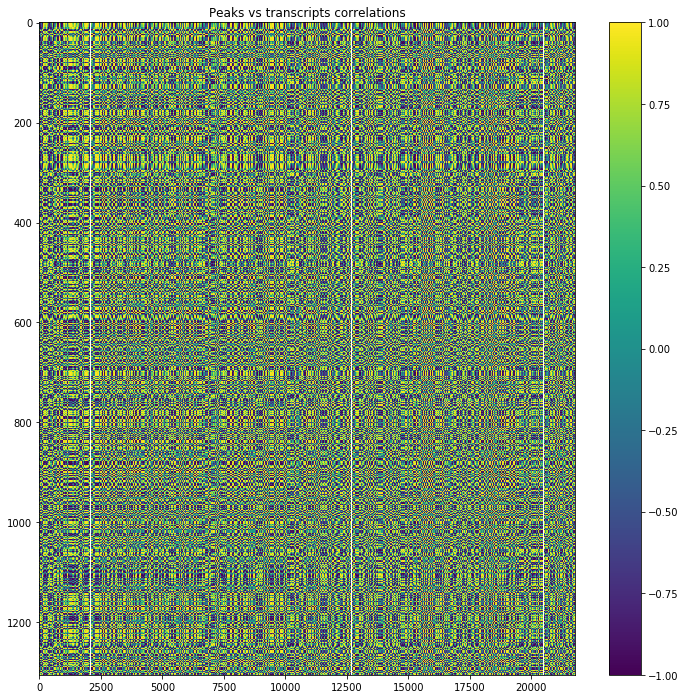

In [17]:
plt.figure(figsize=(12, 12))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.title('Peaks vs transcripts correlations')

In [18]:
corr_df = pd.DataFrame(data=corr, index=pp.columns, columns=rr.columns)
display(corr_df)

,ENSMUSG00000000001,ENSMUSG00000000028,ENSMUSG00000000031,ENSMUSG00000000049,ENSMUSG00000000056,ENSMUSG00000000058,ENSMUSG00000000078,ENSMUSG00000000085,ENSMUSG00000000088,ENSMUSG00000000093,...,ENSMUSG00000110391,ENSMUSG00000110393,ENSMUSG00000110397,ENSMUSG00000110399,ENSMUSG00000110404,ENSMUSG00000110405,ENSMUSG00000110410,ENSMUSG00000110414,ENSMUSG00000110419,ENSMUSG00000110424
1,0.986706,0.941233,0.918698,-0.801395,0.883254,0.924372,0.235060,0.988220,-0.279013,-0.561462,...,0.095496,0.948445,-0.117303,0.918698,-0.738807,-0.009740,-0.993096,-0.918698,0.994023,0.072489
2,0.908399,0.818124,0.990506,-0.614304,0.727476,0.992410,-0.030836,0.912369,-0.523443,-0.322179,...,-0.171625,0.830594,-0.376202,0.990506,-0.890943,-0.274299,-0.926538,-0.990506,0.987428,-0.194324
3,0.999922,0.985780,0.835521,-0.893605,0.951614,0.843462,0.401331,0.999757,-0.106872,-0.697456,...,0.268015,0.989242,0.058084,0.835521,-0.609641,0.165189,-0.998312,-0.835521,0.959640,0.245700
4,0.991994,0.952967,0.903623,-0.822755,0.899828,0.909786,0.270486,0.993160,-0.243670,-0.591380,...,0.131875,0.959413,-0.080867,0.903623,-0.713639,0.026874,-0.996725,-0.903623,0.989360,0.108953
6,0.992257,0.953601,0.902722,-0.823946,0.900741,0.908913,0.272505,0.993403,-0.241635,-0.593071,...,0.133954,0.960002,-0.078776,0.902722,-0.712168,0.028972,-0.996892,-0.902722,0.989053,0.111039
7,0.951641,0.880652,0.967157,-0.703705,0.803845,0.970768,0.088140,0.954545,-0.418498,-0.432376,...,-0.053358,0.890876,-0.263452,0.967157,-0.830677,-0.158099,-0.964673,-0.967157,0.999215,-0.076398
11,0.992575,0.954377,0.901605,-0.825410,0.901862,0.907831,0.274995,0.993697,-0.239122,-0.595152,...,0.136519,0.960724,-0.076195,0.901605,-0.710349,0.031559,-0.997093,-0.901605,0.988667,0.113611
12,0.908399,0.818124,0.990506,-0.614304,0.727476,0.992410,-0.030836,0.912369,-0.523443,-0.322179,...,-0.171625,0.830594,-0.376202,0.990506,-0.890943,-0.274299,-0.926538,-0.990506,0.987428,-0.194324
13,0.962592,0.897961,0.956838,-0.730106,0.825794,0.960983,0.125798,0.965148,-0.383806,-0.466211,...,-0.015505,0.907438,-0.226732,0.956838,-0.808998,-0.120594,-0.973957,-0.956838,0.999998,-0.038586
14,0.908707,0.818549,0.990404,-0.614886,0.727983,0.992318,-0.030098,0.912671,-0.522814,-0.322878,...,-0.170897,0.831005,-0.375518,0.990404,-0.890608,-0.273589,-0.926815,-0.990404,0.987545,-0.193600


## 2. Genes vs genes

Assume 1 transcript == 1 gene

In [19]:
selected_genes = corr_df.columns.values
print selected_genes
print len(selected_genes)

['ENSMUSG00000000001' 'ENSMUSG00000000028' 'ENSMUSG00000000031' ...,
 'ENSMUSG00000110414' 'ENSMUSG00000110419' 'ENSMUSG00000110424']
21794


Load the GeneMania combined data

In [20]:
df = pd.read_csv('../data/genemania/combined/COMBINED.DEFAULT_NETWORKS.BP_COMBINING.txt', sep='\t')
print df.shape

(12360593, 3)


Keep only the genes that we're interested in

In [21]:
df = df.loc[(df['Gene_A'].isin(selected_genes)) & df['Gene_B'].isin(selected_genes)]
df = df.sort_values(['Gene_A', 'Gene_B'])
print df.shape

(6820622, 3)


Construct adjacency matrix

In [22]:
# create an empty s-by-s adj matrix
s = len(selected_genes)
adj = lil_matrix((s, s))
print adj.shape

# build index
idx = {}
for i, val in enumerate(selected_genes):
    idx[val] = i

# populate adj matrix
count = 0
total = df.shape[0]
for i, row in df.iterrows():
    
    if count % 100000 == 0:
        print 'Processing %.2f%%' % (float(count) / total * 100)

    first = row['Gene_A']
    first_pos = idx[first]

    second = row['Gene_B']
    second_pos = idx[second]
    
    val = row['Weight']
    adj[first_pos, second_pos] = val
    
    count += 1

(21794, 21794)
Processing 0.00%
Processing 1.47%
Processing 2.93%
Processing 4.40%
Processing 5.86%
Processing 7.33%
Processing 8.80%
Processing 10.26%
Processing 11.73%
Processing 13.20%
Processing 14.66%
Processing 16.13%
Processing 17.59%
Processing 19.06%
Processing 20.53%
Processing 21.99%
Processing 23.46%
Processing 24.92%
Processing 26.39%
Processing 27.86%
Processing 29.32%
Processing 30.79%
Processing 32.26%
Processing 33.72%
Processing 35.19%
Processing 36.65%
Processing 38.12%
Processing 39.59%
Processing 41.05%
Processing 42.52%
Processing 43.98%
Processing 45.45%
Processing 46.92%
Processing 48.38%
Processing 49.85%
Processing 51.31%
Processing 52.78%
Processing 54.25%
Processing 55.71%
Processing 57.18%
Processing 58.65%
Processing 60.11%
Processing 61.58%
Processing 63.04%
Processing 64.51%
Processing 65.98%
Processing 67.44%
Processing 68.91%
Processing 70.37%
Processing 71.84%
Processing 73.31%
Processing 74.77%
Processing 76.24%
Processing 77.71%
Processing 79.17%
Pr

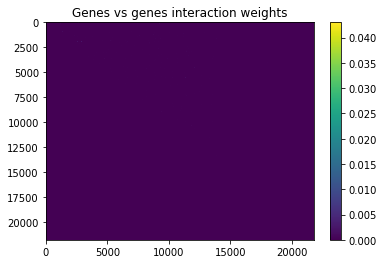

In [23]:
plt.imshow(adj.todense(), aspect='auto')
plt.colorbar()
plt.title('Genes vs genes interaction weights')

In [24]:
nnz = adj.count_nonzero()
total = adj.shape[0] * adj.shape[1]

print nnz
print total
percent = float(nnz) / total * 100
print np.sqrt(total*percent/100)
print percent

6820622
474978436
2611.63205678
1.43598561178


In [25]:
adj_df = pd.DataFrame(adj.todense(), index=selected_genes, columns=selected_genes)

## 3. Peaks vs peaks

In [26]:
peak_corr = generate_correlation_map(pp.values[0:3, :].transpose(), pp.values[0:3, :].transpose())
print peak_corr.shape

(1306, 1306)


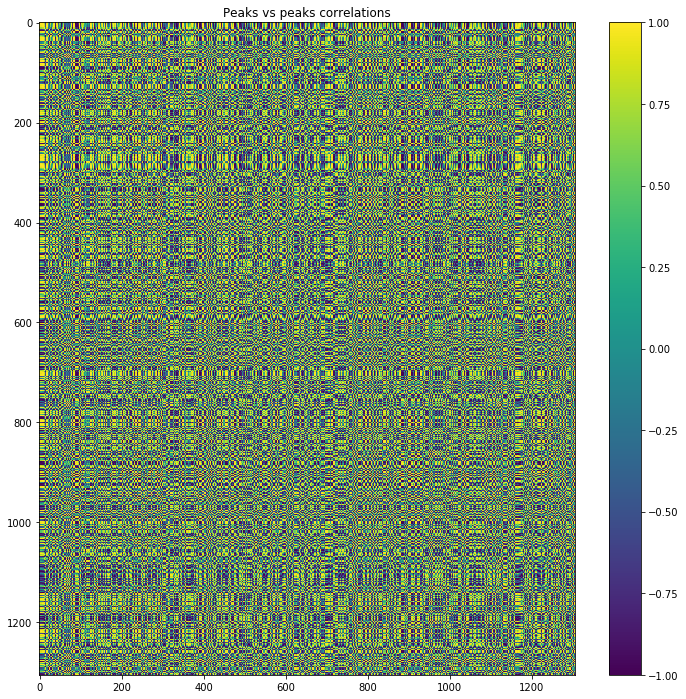

In [27]:
plt.figure(figsize=(12, 12))
plt.imshow(peak_corr, aspect='auto')
plt.colorbar()
plt.title('Peaks vs peaks correlations')

In [28]:
peak_corr_df = pd.DataFrame(data=peak_corr, index=pp.columns, columns=pp.columns)
display(peak_corr_df)

,1,2,3,4,6,7,11,12,13,14,...,2876,2879,2884,2887,2889,2891,2893,2903,2918,2920
1,1.000000,0.964270,0.984606,0.999330,0.999251,0.988916,0.999147,0.964270,0.993829,0.964466,...,-0.873355,0.196390,0.959549,0.624918,-0.914114,-0.198061,-0.984432,-0.893941,0.949850,-0.947081
2,0.964270,1.000000,0.903122,0.953925,0.953294,0.992916,0.952509,1.000000,0.987705,1.000000,...,-0.971188,-0.070388,0.850679,0.809410,-0.774039,-0.450656,-0.995822,-0.743268,0.998754,-0.998280
3,0.984606,0.903122,1.000000,0.990345,0.990634,0.947742,0.990984,0.903122,0.959143,0.903439,...,-0.774774,0.364750,0.993988,0.478843,-0.970911,-0.023688,-0.938557,-0.958517,0.880571,-0.876395
4,0.999330,0.953925,0.990345,1.000000,0.999998,0.982818,0.999989,0.953925,0.989103,0.954147,...,-0.854937,0.232155,0.969213,0.595918,-0.928345,-0.162044,-0.977338,-0.909749,0.937765,-0.934694
6,0.999251,0.953294,0.990634,0.999998,1.000000,0.982428,0.999997,0.953294,0.988791,0.953517,...,-0.853847,0.234195,0.969727,0.594232,-0.929123,-0.159973,-0.976891,-0.910619,0.937034,-0.933946
7,0.988916,0.992916,0.947742,0.982818,0.982428,1.000000,0.981942,0.992916,0.999283,0.993004,...,-0.935994,0.048630,0.907112,0.733904,-0.843782,-0.341399,-0.999618,-0.817489,0.985751,-0.984243
11,0.999147,0.952509,0.990984,0.999989,0.999997,0.981942,1.000000,0.952509,0.988402,0.952733,...,-0.852497,0.236711,0.970356,0.592148,-0.930077,-0.157418,-0.976335,-0.911685,0.936127,-0.933018
12,0.964270,1.000000,0.903122,0.953925,0.953294,0.992916,0.952509,1.000000,0.987705,1.000000,...,-0.971188,-0.070388,0.850679,0.809410,-0.774039,-0.450656,-0.995822,-0.743268,0.998754,-0.998280
13,0.993829,0.987705,0.959143,0.989103,0.988791,0.999283,0.988402,0.987705,1.000000,0.987820,...,-0.921992,0.086419,0.922400,0.707655,-0.863500,-0.305561,-0.997853,-0.838712,0.978674,-0.976841
14,0.964466,1.000000,0.903439,0.954147,0.953517,0.993004,0.952733,1.000000,0.987820,1.000000,...,-0.971012,-0.069651,0.851067,0.808976,-0.774507,-0.449997,-0.995890,-0.743761,0.998717,-0.998236


## 4. Pathway data

Create peak-vs-peak adjacency matrix if they're in the same pathway.

In [29]:
from collections import OrderedDict

Read KEGG pathway data

In [30]:
robjects.r['load']('../data/kegg/pathways2Compounds.RData')
a = robjects.r['pathways2Compounds']
x = OrderedDict(zip(a.names, map(list,list(a))))

print x.keys()[0:10]
print
print x['path:map00010']
print len(x)

['path:map00010', 'path:map00020', 'path:map00030', 'path:map00040', 'path:map00051', 'path:map00052', 'path:map00053', 'path:map00061', 'path:map00062', 'path:map00071']

['Pyruvate', 'Acetyl-CoA', 'D-Glucose', 'Acetate', 'Oxaloacetate', 'Thiamin diphosphate', 'Phosphoenolpyruvate', 'Acetaldehyde', 'D-Glucose 1-phosphate', 'Glycerone phosphate', 'D-Glyceraldehyde 3-phosphate', '(S)-Lactate', '3-Phospho-D-glycerate', 'beta-D-Glucose', '3-Phospho-D-glyceroyl phosphate', 'alpha-D-Glucose', 'Ethanol', '2-Phospho-D-glycerate', 'alpha-D-Glucose 6-phosphate', '2,3-Bisphospho-D-glycerate', 'beta-D-Glucose 6-phosphate', 'Salicin', '2-(alpha-Hydroxyethyl)thiamine diphosphate', 'beta-D-Fructose 6-phosphate', 'beta-D-Fructose 1,6-bisphosphate', 'Arbutin', 'Arbutin 6-phosphate', 'Salicin 6-phosphate', 'Enzyme N6-(lipoyl)lysine', 'Enzyme N6-(dihydrolipoyl)lysine', '[Dihydrolipoyllysine-residue acetyltransferase] S-acetyldihydrolipoyllysine']
383


Create the mapping from metabolite names to peak indices in the dataframe

In [31]:
s, s = peak_corr.shape
print s

peak_names_to_indices = defaultdict(set)
idx = 0
idx_to_pid = {}
for peakid, row in metadata_peaks.iterrows():
    try:
        pimp_annots = row['PiMP Annotation']
        name = row['PiMP Annotation'].split(',')
        for n in name:
            peak_names_to_indices[n].add(idx)
            assert idx < s, 'idx=%d, s=%d' % (idx, s)
            idx_to_pid[idx] = peakid
    except AttributeError: # skip peaks that don't have identifications
        continue
    finally:
        idx += 1

1306


Loop through all the pathways, assigning peaks (based on matching names) to the adjacency matrix

In [32]:
data = []
peak_pathway_adj = np.zeros_like(peak_corr)
for pathway_id in x:

    # ix = int(id_str.split(':')[1].replace('map', ''))
    members = set()    
    metabolite_names = x[pathway_id]
    for name in metabolite_names:        
        indices = peak_names_to_indices[name]
        if len(indices) > 0:

            members.add((name, tuple(indices),))
            
            # populate matrix
            for i in indices:
                assert i < s, 'i=%d, s=%d' % (i, s)                
                for j in indices:
                    peak_pathway_adj[i, j] = 1
                    
    if len(members)>0:
        for metabolite_name, peak_indices in members:
            for i in indices:
                data.append((pathway_id, metabolite_name, idx_to_pid[i]))
        
pathway_peaks_df = pd.DataFrame(data, columns=['pathway_id', 'metabolite_name', 'peak_id'])
display(pathway_peaks_df)

,pathway_id,metabolite_name,peak_id
0,path:map00072,(R)-3-Hydroxybutanoate,1611
1,path:map00072,(R)-3-Hydroxybutanoate,2205
2,path:map00072,(R)-3-Hydroxybutanoate,983
3,path:map00232,5-Acetylamino-6-formylamino-3-methyluracil,784
4,path:map00232,5-Acetylamino-6-amino-3-methyluracil,784
5,path:map00250,L-Glutamate,1700
6,path:map00250,N-Acetyl-L-aspartate,1700
7,path:map00250,5-Phosphoribosylamine,1700
8,path:map00250,L-Asparagine,1700
9,path:map00250,4-Aminobutanoate,1700


In [33]:
nnz = np.count_nonzero(peak_pathway_adj)
total = s*s 
print nnz
print total
print float(nnz)/total*100

2492
1705636
0.146103858033


In [34]:
peak_pathway_adj_df = pd.DataFrame(data=peak_pathway_adj, index=pp.columns, columns=pp.columns)
display(peak_pathway_adj_df)

,1,2,3,4,6,7,11,12,13,14,...,2876,2879,2884,2887,2889,2891,2893,2903,2918,2920
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


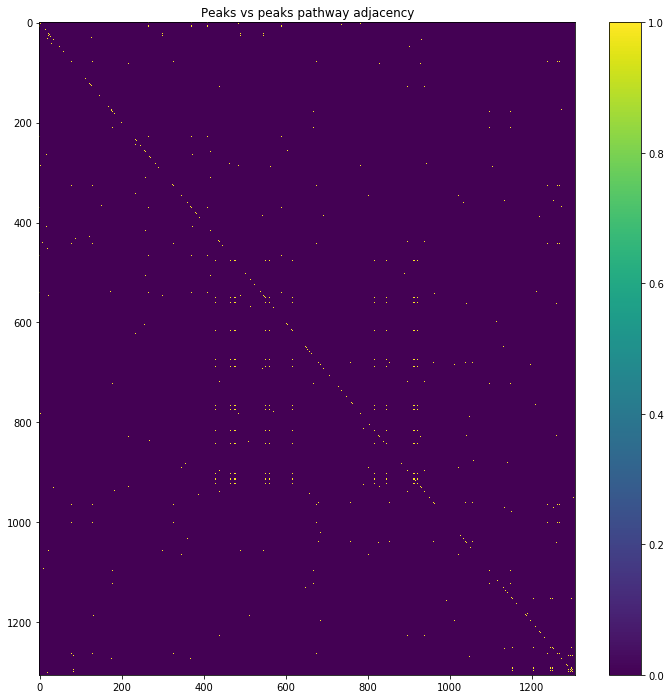

In [35]:
plt.figure(figsize=(12, 12))
plt.imshow(peak_pathway_adj_df, aspect='auto')
plt.colorbar()
plt.title('Peaks vs peaks pathway adjacency')

Store the pathway metadata too

In [36]:
robjects.r['load']('../data/kegg/pathways.RData')
df = robjects.r['pathways']

pathway_names = []
for ix, row in df.iterrows():
    pathway_names.append((row['id'], row['name'],))
    
pathway_names_df = pd.DataFrame(pathway_names, columns=['pathway_id', 'pathway_name']).set_index('pathway_id')
display(pathway_names_df)

,pathway_name
pathway_id,
path:map00010,Glycolysis / Gluconeogenesis
path:map00020,Citrate cycle (TCA cycle)
path:map00030,Pentose phosphate pathway
path:map00040,Pentose and glucuronate interconversions
path:map00051,Fructose and mannose metabolism
path:map00052,Galactose metabolism
path:map00053,Ascorbate and aldarate metabolism
path:map00061,Fatty acid biosynthesis
path:map00062,Fatty acid elongation


## 5. Dump everything out to HDF5 file

In [37]:
filename = '../data/data_%d_%s_%s.h5' % (time, parasite, treatment)
hdf = HDFStore(filename, complevel=9, complib='bzip2')
hdf.put('peak_vs_transcript', corr_df)
hdf.put('peak_vs_peak', peak_corr_df)
hdf.put('transcript_vs_transcript', adj_df)
hdf.put('pathway_peaks_df', pathway_peaks_df)
hdf.put('pathway_names_df', pathway_names_df)
hdf.put('peak_pathway_adj_df', peak_pathway_adj_df)
hdf.close()